# Introduction

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset.

Once the data is in a structured format, you can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.



**All the 3 tasks of web scraping, cleaning and clustering are implemented in the same notebook for the ease of evaluation.
Installing and Importing the required Libraries**


# Import libraries

In [62]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Get the Data

In [63]:
# Use BeautifulSoup and get the table from url:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')
table = soup.find('table')


# Create a function that:

**Split each item in the table into 3 different values:**

    postal
    borough
    neighborhood Verify, format and add these values into the Dataframe df



In [64]:
def add_to_database(item):    
    if len(item) == 2:
        item=item[0]
    #get Pastal Code, the 1st 3 characters of the string:
    postal  = item[:3]    
    #initializa borough and neigh to 'NA':
    borough = 'NA'
    neighb  = 'NA'
    #Verify if we have a parentesis (neighborhoods were between paranthesis before wikipedia's update):
    if ("(" in item):
        item = item.split("(")
        #update neighborhood (between paranthesis):
        borough = item[0][3-len(item[0]):]
        # replace '/' with ',' and ')' with nothing:
        neighb  = item[1].replace(" /", ",").replace("/", ",").replace(")", "")
    else:
        #If there is no parenthesis, then we only have to update borough
        borough = item[3-len(item):]
    if neighb  == 'NA':
        neighb = borough        
    #Add postal, borough and neighborhood to dataframe: 
    global df
    if borough.upper() != 'NOT ASSIGNED' and borough != 'NA':
         df = df.append({'PostalCode': postal,
                         'Borough': borough,
                         'Neighborhood': neighb}, ignore_index=True)

In [65]:
list=[]
j=0
for row in table.find_all('tr'):
    old_cell_format=''
    i=0
    j=j+1
    if j != 1:
        for cell in row.find_all('td'):        
            i=i+1
            celtxt = cell.text.replace('\n','')
            if i != 3:
                old_cell_format=old_cell_format + celtxt
            else:
                if len(celtxt) > 0:                    
                    old_cell_format=old_cell_format + '(' + celtxt + ')'
        list.append(old_cell_format)    
list[0:10]

['M1ANot assigned',
 'M2ANot assigned',
 'M3ANorth York(Parkwoods)',
 'M4ANorth York(Victoria Village)',
 'M5ADowntown Toronto(Regent Park / Harbourfront)',
 'M6ANorth York(Lawrence Manor / Lawrence Heights)',
 "M7ADowntown Toronto(Queen's Park / Ontario Provincial Government)",
 'M8ANot assigned',
 'M9AEtobicoke(Islington Avenue)',
 'M1BScarborough(Malvern / Rouge)']

# Call function to populate the database

In [66]:
df = pd.DataFrame(columns=['PostalCode','Borough','Neighborhood'])
for item in list:
    add_to_database(item)              
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [67]:
df.shape


(103, 3)

# Get Latitudes and Longitudes

In [68]:
lat_lng = pd.read_csv('http://cocl.us/Geospatial_data')
#set index to Postal Code to make things easier:
lat_lng.set_index('Postal Code', inplace=True)

In [69]:
for i,row in df.iterrows():    
    df.at[i,'Latitude']  = lat_lng.loc[ row['PostalCode'] ][0]
    df.at[i,'Longitude'] = lat_lng.loc[ row['PostalCode'] ][1]
df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [70]:
filter='Toronto'
dft = df[df['Borough'].str.contains(filter)]
dft.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


# Credentials to access Foursquare

In [71]:
CLIENT_ID = 'JT1BAPXFGLO2H4S5OO4MZTX5ZMLZ2P5O4RL122HGK21AJ1HM' # your Foursquare ID
CLIENT_SECRET = 'ULEYB3HDD2VDBMJ2WZM145GUXWRXJ2OIH1WW1BODQ4IJNMSF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 800 # define radius

In [72]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Get venues from Foursquare, and store into toronto_venues

In [73]:
toronto_venues = getNearbyVenues(names=dft['Neighborhood'],latitudes=dft['Latitude'],longitudes=dft['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town,

In [74]:
toronto_venues.shape

(1623, 7)

In [75]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


# How many venues for each neighborhood

In [76]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
Business reply mail Processing CentrE,17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,17,17,17,17,17,17
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35


# Unique categories

In [77]:
len(toronto_venues['Venue Category'].unique())

226

# Encoding

In [78]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
toronto_onehot.head()

,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [79]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.017241,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.017241,0.034483,0.000000,0.000000,0.00,0.017241,0.017241,0.000000,0.034483,0.000000,0.000000,0.017241,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.034483,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.017241,0.051724,0.068966,0.000000,0.000,0.000000,0.00,0.000000,0.017241,0.000000,0.017241,0.000000,0.00,0.017241,0.000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.00,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.01724

In [80]:
toronto_grouped.shape[0]

39

# Top 5 Venues for each Neighborhood

In [81]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.07
1  Cocktail Bar  0.05
2        Bakery  0.03
3      Beer Bar  0.03
4    Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
                   venue  freq
0                   Café  0.12
1            Coffee Shop  0.08
2         Breakfast Spot  0.08
3              Nightclub  0.08
4  Performing Arts Venue  0.04


----Business reply mail Processing CentrE----
                venue  freq
0  Light Rail Station  0.12
1         Yoga Studio  0.06
2              Garden  0.06
3                Park  0.06
4          Comic Shop  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3           Airport  0.06
4               Bar  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.20
1  Italian Restaurant  0.08
2    

# Most Comon Venues

In [82]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Italian Restaurant,Cheese Shop,Restaurant,Seafood Restaurant,Beer Bar,Farmers Market,Café
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Performing Arts Venue,Bar,Music Venue,Burrito Place,Grocery Store,Gym
2,Business reply mail Processing CentrE,Light Rail Station,Yoga Studio,Auto Workshop,Comic Shop,Park,Pizza Place,Burrito Place,Restaurant,Brewery,Smoke Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Harbor / Marina,Coffee Shop,Sculpture Garden,Boutique,Bar,Boat or Ferry
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Bubble Tea Shop,Burger Joint,Ice Cream Shop,Salad Place,Fried Chicken Joint,Restaurant


In [84]:
neighborhoods_venues_sorted.shape[0]

39

# Cluster Neighborhoods with K-Means

In [85]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
# k-means clustering:
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:]

array([1, 1, 1, 9, 1, 8, 1, 1, 1, 7, 8, 1, 4, 1, 1, 8, 1, 1, 6, 1, 3, 1,
       1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1], dtype=int32)

In [86]:
kmeans.labels_.shape[0]

39

In [87]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dft

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Pub,Bakery,Park,Theater,Restaurant,Café,Breakfast Spot,Farmers Market,Spa
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Diner,Discount Store,Bar,Hobby Shop,Spa,Café,Beer Bar,Yoga Studio
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Restaurant,Cosmetics Shop,Japanese Restaurant,Middle Eastern Restaurant,Italian Restaurant,Ramen Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Italian Restaurant,Clothing Store,Department Store,Seafood Restaurant,Moroccan Restaurant
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,5,Park,Pub,Trail,Health Food Store,Yoga Studio,Diner,Deli / Bodega,Department Store,Dessert Shop,Distribution Center


# Vizualize Neighborhoods Clusters in Folium

In [89]:
# create Folium map for Toronto Neighborhoods:
map_clusters = folium.Map(location=[dft.loc[2,'Latitude'], dft.loc[2,'Longitude'] ], zoom_start=12)

# set color scheme for the clusters:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map:
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

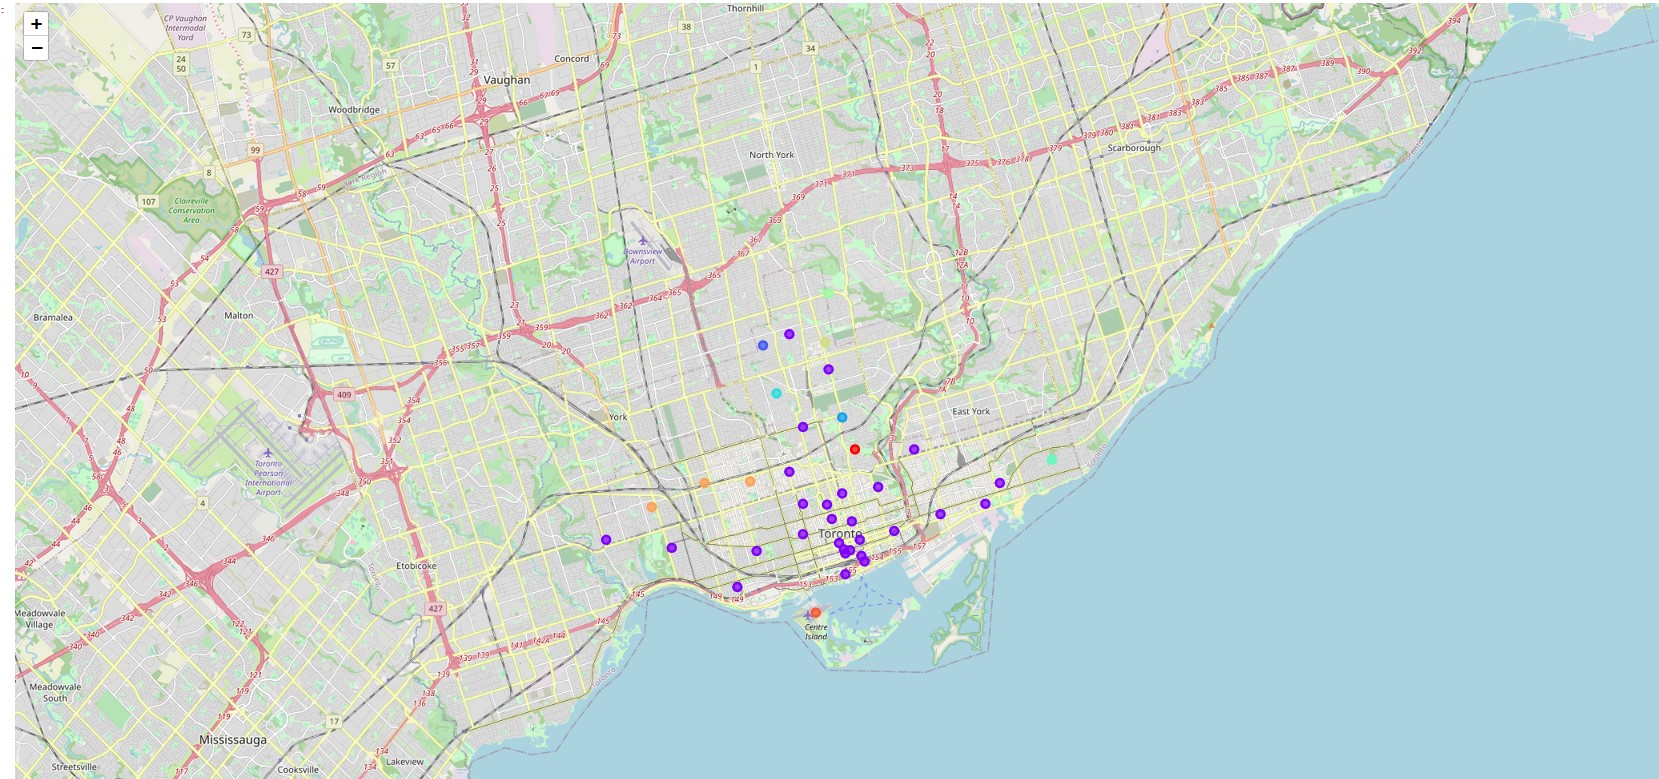

in case the output of the code do not charge.